<a href="https://colab.research.google.com/github/lucapernice/Machine-Learning-Challenge/blob/main/Smote_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMOTE ALGORITHM
## Implementation test

Look at https://imbalanced-learn.org/stable/ for info

In [ ]:
!pip install imbalanced_learn

Import all the libraries


In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd




### DATA


Obtain the data file

In [ ]:
FFILE = './creditcard.csv'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://datahub.io/machine-learning/creditcard/r/creditcard.csv"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://datahub.io/machine-learning/creditcard/r/creditcard.csv"

Either the file is missing or not readable, download it
--2023-07-03 07:31:07--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2023-07-03 07:31:08--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv  

In [ ]:
data = pd.read_csv('creditcard.csv')

data.head()




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [ ]:
data.shape

(284807, 31)

In [ ]:
data['Class']

0         '0'
1         '0'
2         '0'
3         '0'
4         '0'
         ... 
284802    '0'
284803    '0'
284804    '0'
284805    '0'
284806    '0'
Name: Class, Length: 284807, dtype: object

In [ ]:
data.isnull().values.any()

False

Occurence of '0' (not fraud) and '1' (fraud) classes

In [ ]:

data['Class'].value_counts()

'0'    284315
'1'       492
Name: Class, dtype: int64

In [ ]:
two_dim_data = data.loc[:,['V1','V2','Class']]



In [ ]:
mask = two_dim_data['Class']!=two_dim_data['Class'][1]
fraud = two_dim_data[mask][:]
mask = two_dim_data['Class']==two_dim_data['Class'][1]
not_fraud = two_dim_data[mask][:]


''

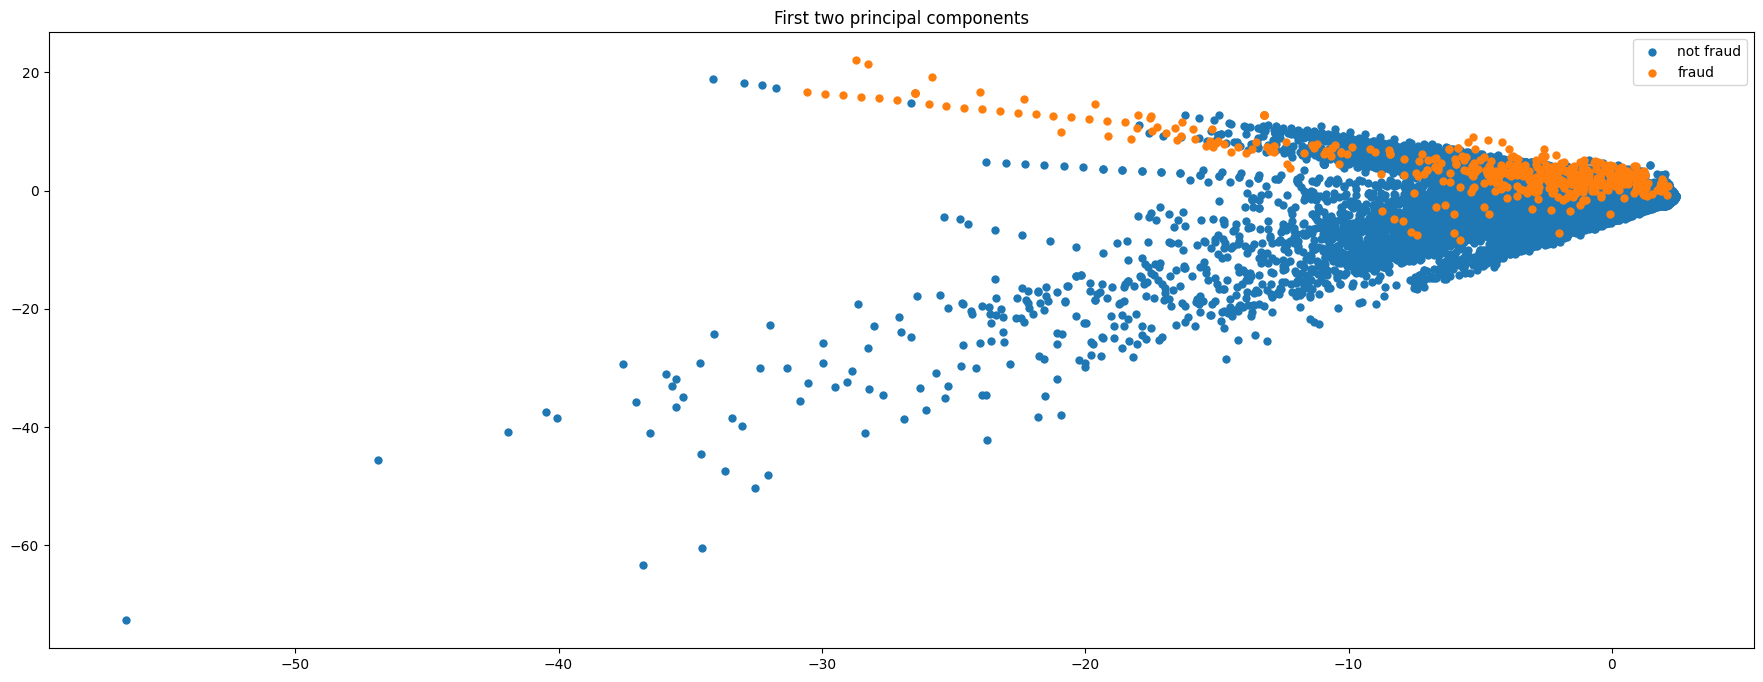

In [ ]:
plt.figure(figsize=(22,8))
plt.scatter(not_fraud.loc[:,'V1'],not_fraud.loc[:,'V2'],linewidths = 0.0001, label = 'not fraud')
plt.scatter(fraud.loc[:,'V1'],fraud.loc[:,'V2'],linewidths = 0.0001, label = 'fraud')
plt.legend()
plt.title('First two principal components')
;


### NEURAL NETWORK


In [ ]:
import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from time import time

Custom Dataset for Pytorch

In [ ]:
class MyDataset(Dataset):

  def __init__(self, file_name):
    data = pd.read_csv(file_name)
    data['Class'].replace(data.iloc[0,-1],0,inplace = True)
    data['Class'].replace(data.iloc[541,-1],1,inplace = True)


    x = data.iloc[0:200000,0 : -1].values
    y = data.iloc[0:200000,-1].values



    self.x_train = torch.tensor(x,dtype = torch.float32)
    self.y_train = torch.tensor(y,dtype = torch.float32)


  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.x_train[idx],self.y_train[idx]




In [ ]:
BATCH_SIZE = 15

In [ ]:
train = MyDataset('creditcard.csv')
train_loader=DataLoader(train,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
for values, labels in train_loader:
    print("data batch dimensions:", values.shape)
    print("data label dimensions:", values.shape)
    break

data batch dimensions: torch.Size([15, 30])
data label dimensions: torch.Size([15, 30])


In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()


        self.l1 = nn.Linear(30, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128,1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        x = self.l1(x)

        x = F.relu(x)


        x = self.l2(x)

        x = F.relu(x)

        logits = self.l3(x).squeeze()








        out = logits


        return out

Single batch test

In [ ]:
model = MyModel()
out = model(values)
print(f"Output shape is: {out.shape}  i.e.: batch_size ")

Output shape is: torch.Size([15])  i.e.: batch_size 


In [ ]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Re-instantiate the model to reset the weights/gradients.
# Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = MyModel()
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cuda


In [ ]:
num_epochs = 20
learning_rate = 0.000001

criterion = nn.BCEWithLogitsLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model = model.train()
    start = time()
    ## training step
    for i, (images, labels) in enumerate(train_loader):
        #labels = labels.type(torch.LongTensor)


        images = images.to(device)
        labels = labels.to(device)


        ## forward + backprop + loss
        logits = model(images)

        loss = criterion(logits, labels)

        # Reset the gradients to zero: otherwise they accumulate!
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.item()


    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f}  Time: {time()-start:.2f}")

Epoch: 1 | Loss: 0.0259  Time: 24.73
Epoch: 2 | Loss: 0.0269  Time: 20.57
Epoch: 3 | Loss: 0.0265  Time: 20.60
Epoch: 4 | Loss: 0.0263  Time: 21.75
Epoch: 5 | Loss: 0.0263  Time: 20.70
Epoch: 6 | Loss: 0.0260  Time: 20.34
Epoch: 7 | Loss: 0.0258  Time: 20.89
Epoch: 8 | Loss: 0.0256  Time: 20.71
Epoch: 9 | Loss: 0.0253  Time: 20.36
Epoch: 10 | Loss: 0.0250  Time: 20.83
Epoch: 11 | Loss: 0.0249  Time: 20.76
Epoch: 12 | Loss: 0.0246  Time: 20.80
Epoch: 13 | Loss: 0.0237  Time: 20.47
Epoch: 14 | Loss: 0.0240  Time: 20.85
Epoch: 15 | Loss: 0.0236  Time: 20.55
Epoch: 16 | Loss: 0.0233  Time: 20.02
Epoch: 17 | Loss: 0.0230  Time: 20.55
Epoch: 18 | Loss: 0.0227  Time: 20.87
Epoch: 19 | Loss: 0.0226  Time: 20.99
Epoch: 20 | Loss: 0.0224  Time: 20.67


test loader

In [ ]:
class Testset(Dataset):

  def __init__(self, file_name):
    data = pd.read_csv(file_name)
    data['Class'].replace(data.iloc[0,-1],0,inplace = True)
    data['Class'].replace(data.iloc[541,-1],1,inplace = True)


    x = data.iloc[200001:,0:-1].values
    y = data.iloc[200001:,-1].values

    self.x_test = torch.tensor(x,dtype = torch.float32)
    self.y_test = torch.tensor(y,dtype = torch.float32)

  def __len__(self):
    return len(self.y_test)

  def __getitem__(self, idx):
    return self.x_test[idx],self.y_test[idx]

In [ ]:
test = Testset('creditcard.csv')
test_loader=DataLoader(test,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
m = nn.Sigmoid()

In [ ]:
predictions = []
targets = []
for j, (test_images,test_labels) in enumerate(test_loader):
        #labels = labels.type(torch.LongTensor)


        test_images = test_images.to(device)
        test_labels = test_labels.to(device)


        ## forward + backprop + loss
        res = model(test_images)
        batch_pred = m(res)
        batch_pred = torch.round(batch_pred)
        predictions = predictions + list(batch_pred.cpu().detach().numpy())
        targets = targets + list(test_labels.cpu().detach().numpy())




In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


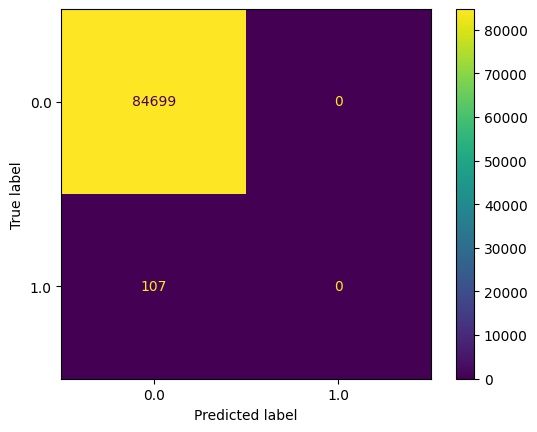

In [ ]:
ConfusionMatrixDisplay.from_predictions(targets, predictions)

In [ ]:
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84699
         1.0       0.00      0.00      0.00       107

    accuracy                           1.00     84806
   macro avg       0.50      0.50      0.50     84806
weighted avg       1.00      1.00      1.00     84806



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SMOTED DATASET

In [ ]:
X_train = data.iloc[0:200000,0 : -1]
y_train = data.iloc[0:200000,-1]

smt = SMOTE()
sm_x_train,sm_y_train = smt.fit_resample(X_train, y_train)






In [ ]:
y_train.value_counts()

'0'    199615
'1'       385
Name: Class, dtype: int64

In [ ]:
sm_y_train.value_counts()


'0'    199615
'1'    199615
Name: Class, dtype: int64

### NEURAL NETWORK WITH SMOTED DATA

In [ ]:
class SMDataset(Dataset):

  def __init__(self, file_name):
    data = pd.read_csv(file_name)
    data['Class'].replace(data.iloc[0,-1],0,inplace = True)
    data['Class'].replace(data.iloc[541,-1],1,inplace = True)




    x = data.iloc[0:200000,0 : -1].values
    y = data.iloc[0:200000,-1].values

    smt = SMOTE()
    sm_x,sm_y = smt.fit_resample(x,y)



    self.x_train = torch.tensor(sm_x,dtype = torch.float32)
    self.y_train = torch.tensor(sm_y,dtype = torch.float32)



  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.x_train[idx],self.y_train[idx]




In [ ]:
sm_train = SMDataset('creditcard.csv')
sm_train_loader=DataLoader(sm_train,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
for values, labels in sm_train_loader:
    print("data batch dimensions:", values.shape)
    print("data label dimensions:", values.shape)
    break

data batch dimensions: torch.Size([15, 30])
data label dimensions: torch.Size([15, 30])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model2 = MyModel()
model2 = model2.to(device)

In [ ]:
num_epochs = 20
learning_rate = 0.000001

criterion = nn.BCEWithLogitsLoss() # loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model2 = model2.train()
    start = time()
    ## training step
    for i, (images, labels) in enumerate(sm_train_loader):
        #labels = labels.type(torch.LongTensor)

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model2(images)

        loss = criterion(logits, labels)

        # Reset the gradients to zero: otherwise they accumulate!
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.item()


    model2.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Time: {time()-start:.2f}")

Epoch: 1 | Loss: 1.8892 | Time: 41.06
Epoch: 2 | Loss: 0.3734 | Time: 40.78
Epoch: 3 | Loss: 0.3008 | Time: 40.79
Epoch: 4 | Loss: 0.2570 | Time: 41.35
Epoch: 5 | Loss: 0.2271 | Time: 40.69
Epoch: 6 | Loss: 0.2041 | Time: 40.76
Epoch: 7 | Loss: 0.1875 | Time: 40.74
Epoch: 8 | Loss: 0.1746 | Time: 40.61
Epoch: 9 | Loss: 0.1640 | Time: 40.75
Epoch: 10 | Loss: 0.1545 | Time: 40.54
Epoch: 11 | Loss: 0.1469 | Time: 40.39
Epoch: 12 | Loss: 0.1405 | Time: 40.59
Epoch: 13 | Loss: 0.1354 | Time: 40.03
Epoch: 14 | Loss: 0.1302 | Time: 40.26
Epoch: 15 | Loss: 0.1254 | Time: 40.58
Epoch: 16 | Loss: 0.1219 | Time: 40.12
Epoch: 17 | Loss: 0.1190 | Time: 40.06
Epoch: 18 | Loss: 0.1156 | Time: 40.94
Epoch: 19 | Loss: 0.1131 | Time: 40.04
Epoch: 20 | Loss: 0.1111 | Time: 40.31


In [ ]:
sm_predictions = []
sm_targets = []
for j, (test_sm_images,test_sm_labels) in enumerate(test_loader):
        #labels = labels.type(torch.LongTensor)


        test_sm_images = test_sm_images.to(device)
        test_sm_labels = test_sm_labels.to(device)


        ## forward + backprop + loss
        sm_res = model2(test_sm_images)
        sm_batch_pred = m(sm_res)
        sm_batch_pred = torch.round(sm_batch_pred)
        sm_predictions = sm_predictions + list(sm_batch_pred.cpu().detach().numpy())
        sm_targets = sm_targets + list(test_sm_labels.cpu().detach().numpy())




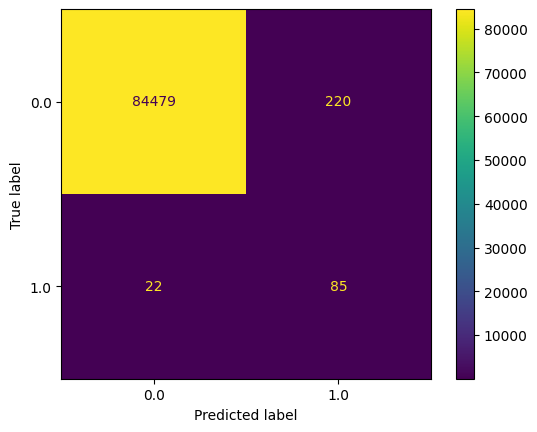

In [ ]:
ConfusionMatrixDisplay.from_predictions(sm_targets, sm_predictions)

In [ ]:
print(classification_report(sm_targets, sm_predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84699
         1.0       0.28      0.79      0.41       107

    accuracy                           1.00     84806
   macro avg       0.64      0.90      0.71     84806
weighted avg       1.00      1.00      1.00     84806

